# CS4248 NLP Project Team 18

## Installing necessary libraries

*Note*: Put libraries that need to be installed with `!pip install LIBRARY` so that we can ensure consistency in packages

In [23]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install tensorflow
!pip install shap


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
                                              0.0/377.0 MB ? eta -:--:--
                                             0.5/377.0 MB 14.2 MB/s eta 0:00:27
                                             1.2/377.0 MB 15.2 MB/s eta 0:00:25
                                             2.1/377.0 MB 16.8 MB/s eta 0:00:23
                                             3.2/377.0 MB 18.8 MB/s eta 0:00:20
                                             4.3/377.0 MB 19.4 MB/s eta 0:00:20
                                             4.9/377.0 MB 20.7 MB/s eta 0:00:18
                                             5.4/377.0 MB 17.2 MB/s eta 0:00:22
                                             6.7/377.0 MB 18.6 MB/s eta 0:00:20
                                             7.6/377.0 MB 19.5 MB/s eta 0:00:19
                                             9.4/377.0 MB 20.7 MB/s eta 0:00:18
     -                                      11.0/377.0 MB 23.4 MB/s eta 0:00:16
     -                                      


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Reading Data

In [2]:
import pandas as pd

DATA_FILEPATH = "raw_data/fulltrain.csv"

df = pd.read_csv(DATA_FILEPATH, header=None)
df.head()

,0,1
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [3]:
X = df[1]
y = df[0]

print(X.head())
print(y.head())

0    A little less than a decade ago, hockey fans w...
1    The writers of the HBO series The Sopranos too...
2    Despite claims from the TV news outlet to offe...
3    After receiving 'subpar' service and experienc...
4    After watching his beloved Seattle Mariners pr...
Name: 1, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: 0, dtype: int64


## Data Analysis

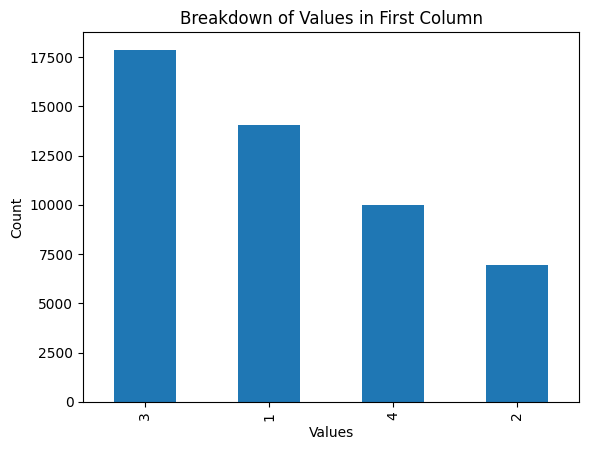

In [8]:
import matplotlib.pyplot as plt

value_counts = df[0].value_counts()
value_counts.plot(kind='bar')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Breakdown of Text Classification')
plt.show()

## Preprocessing

## Feature Engineering

## Model Training & Evaluation

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 10000

vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_matrix = vectorizer.fit_transform(X)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

## Settings for train test split

In [5]:
## Settings

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Note: Change this to fit the algorithm below
# X are the features
X = tfidf_df
# y are the outputs
y = y
# test_size is the size of the test (0 < test_size < 1)
test_size = 0.2
# seed for random split
seed = 40
## End of Note

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### Logistic Regression

In [15]:

model = LogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation_metrics = [("Accuracy", accuracy_score), ("Confusion Matrix", confusion_matrix)]

for evaluation_metric_name, evaluation_metric_func in evaluation_metrics:
    print(f"{evaluation_metric_name}:\n{evaluation_metric_func(y_test, y_pred)}")
    

Accuracy:
0.9639750281445093
Confusion Matrix:
[[2689   11   46   29]
 [  17 1349   54    8]
 [  30   27 3482   18]
 [  58    3   51 1899]]


In [16]:
evaluation_metrics = [("Accuracy", accuracy_score), ("Confusion Matrix", confusion_matrix)]

for evaluation_metric_name, evaluation_metric_func in evaluation_metrics:
    print(f"{evaluation_metric_name}:\n{evaluation_metric_func(y_test, y_pred)}")
f1_score(y_test, y_pred, average="macro")

Accuracy:
0.9639750281445093
Confusion Matrix:
[[2689   11   46   29]
 [  17 1349   54    8]
 [  30   27 3482   18]
 [  58    3   51 1899]]


0.9623921309659836

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
loss, accuracy = model.evaluate(X_test, y_test)


## RNN

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense

X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

num_samples, num_features = X_train_array.shape
timesteps = 1  # You may need to adjust this depending on your data

X_train_reshaped = X_train_array.reshape(num_samples, timesteps, num_features)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], timesteps, X_test_array.shape[1])


# create model here
model = tf.keras.Sequential([
    SimpleRNN(units=32, input_shape=(timesteps, num_features)),
    Dense(units=4)
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32)
loss, accuracy = model.evaluate(X_test_reshaped, y_test)

C:\Users\User\Documents\GitHub\CS4248-NLP_Project\nlpenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3350 - loss: 1.4576
Epoch 2/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2070 - loss: 0.2639
Epoch 3/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1962 - loss: 0.2381
Epoch 4/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1897 - loss: 0.2283
Epoch 5/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2031 - loss: 0.2168
Epoch 6/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2010 - loss: 0.2082
Epoch 7/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1786 - loss: 0.1989
Epoch 8/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1721 - loss: 0.1856
Epoch 9/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1758 - loss: 0.1759
Epoch 10/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1926 - loss: 0.1644
Epoch 11/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1974 - loss: 0.1543
Epoch 12/100
1222/1

## LSTM

In [35]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.metrics import f1_score
import numpy as np

# Assuming df is your pandas DataFrame with a column named 'text' containing the sentences
# and a column named 'label_column' containing the labels
# Example DataFrame:
# df = pd.DataFrame({'text': ["This is sentence 1.", "Another sentence.", "Yet another sentence."],
#                    'label_column': [0, 1, 1]})

X = df[1].values
y = df[0].values

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Padding
max_sequence_length = 100 # max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert to Numeric
X = padded_sequences
y = y

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Adjust as needed
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=128, implementation=2))  # Disable CuDNN
model.add(Dense(units=1, activation='sigmoid'))

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a data generator
def data_generator(X, y, batch_size):
    num_samples = X.shape[0]
    while True:
        indices = np.random.permutation(np.arange(num_samples))
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            yield X[batch_indices], y[batch_indices]

# Train Model with Data Generator
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
train_generator = data_generator(X_train, y_train, batch_size)

# Train Model with Generator
model.fit(train_generator, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=(X_test, y_test))

# Evaluate Model
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score (macro):", f1)



MemoryError: Unable to allocate 17.7 GiB for an array with shape (39083, 121733) and data type int32

# Evaluation

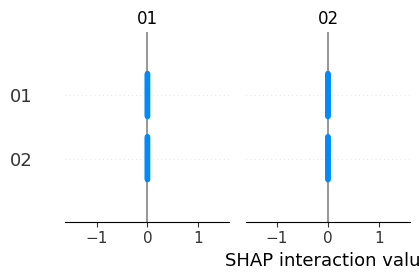

In [42]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_test[50:100])
shap.summary_plot(shap_values, X_test[50:100], max_display=2)

In [38]:
vectorizer.get_feature_names_out()

array(['00', '000', '01', ..., 'zone', 'zones', 'zoo'], dtype=object)

In [39]:
shap_values[0].shape
X_test.shape
X_train.shape

(39083, 10000)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (10000, 4, 4) and arg 3 with shape (10000,).

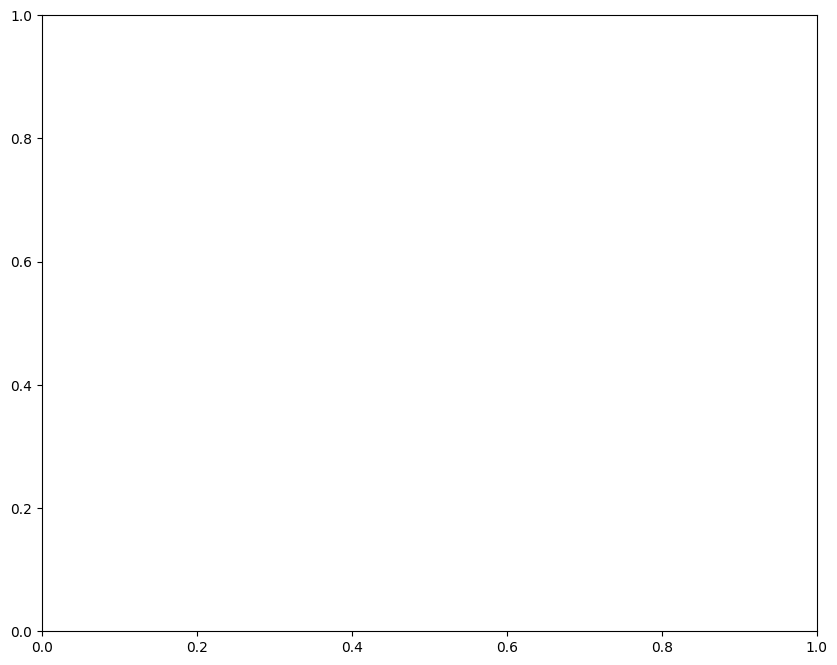